<hr style="color:#DA01B5">

# Diseño de una Red Bayesiana


<hr style="color:#DA01B5">

Una vez los datos están preparados y guardados, ya se puede crear la red bayesiana. 

In [282]:
# Cargamos los paquetes necesarios
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.estimators import HillClimbSearch
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split


<hr style="color:#DA01B5">

## Momento A


<hr style="color:#DA01B5">

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Observación de los datos </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

Se dividen los datos en conjunto de train y de validación. 

\* Se eliminan aquellas filas donde la actividad sea Idle ya que se quiere inferir sobre las actividades y estas filas reducen la precisión del modelo.

In [284]:
letter = 'A'
df = pd.read_csv(f'Data\\data_{letter}.csv', sep=',', index_col=0)
# Eliminamos la ultima columna que no contiene información relevante
df = df.drop(columns=['DAY'])

# Eliminamos las filas que tienen un valor 0 en la columna 'Activity'
df = df[df['Activity'] != 0]
# Dividimos ahora trainval en train y validación
df_train, df_val = train_test_split(df, test_size=0.25, random_state=40, stratify=df['Activity'])

print("\n\033[1;32mDatos de entrenamiento:\033[0m")
print(df_train.shape)
print(df_train.head())
print("\n\033[1;32mDatos de validación:\033[0m")
print(df_val.shape)
df_val.head()



Datos de entrenamiento:
(2352, 78)
     C02  C04  C05  C07  C08  C09  C10  C12  C13  C14  ...  05,02  05,03  \
C01                                                    ...                 
0      0    0    0    0    0    0    0    0    0    1  ...      0      0   
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    0    0    0    0    0    1  ...      0      0   

     05,04  05,05  05,06  05,07  05,08  05,09  05,10  Activity  
C01                                                             
0        0      0      0      0      0      0      0         5  
0        0      0      1      0      0      0      0         2  
0        0      0      0      0      0      0      0        22  
0        0      0      0      0      0      0      0         2  
0        0      0      0      0      0   

,C02,C04,C05,C07,C08,C09,C10,C12,C13,C14,...,"05,02","05,03","05,04","05,05","05,06","05,07","05,08","05,09","05,10",Activity
C01,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,17
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,22


<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Modelo </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

Se utiliza el método de aprendizaje **HillClimbSearch** para estructurar un modelo gráfico bayesiano a partir de los datos de **df**. El objetivo es encontrar la mejor estructura (red de relaciones entre variables) que explique esos datos. 

Para estimar la estructura del modelo se usa **hc.estimate**. Su criterio de optimización será el **k2** que penaliza la complejidad para evitar el sobreajuste. 

In [286]:
# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df_train)
model = hc.estimate(scoring_method="k2", epsilon=1e-13, max_iter=1e6, max_indegree=15, show_progress=True)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C02': 'N', 'C04': 'N', 'C05': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D05': 'N', 'D07': 'N', 'D08': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'S09': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'SM5': 'N', 'TV0': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': '

El modelo aprendido representa dependencias probabilísticas entre sensores y actividad.

Se grafica el modelo para poder visualizarlo.

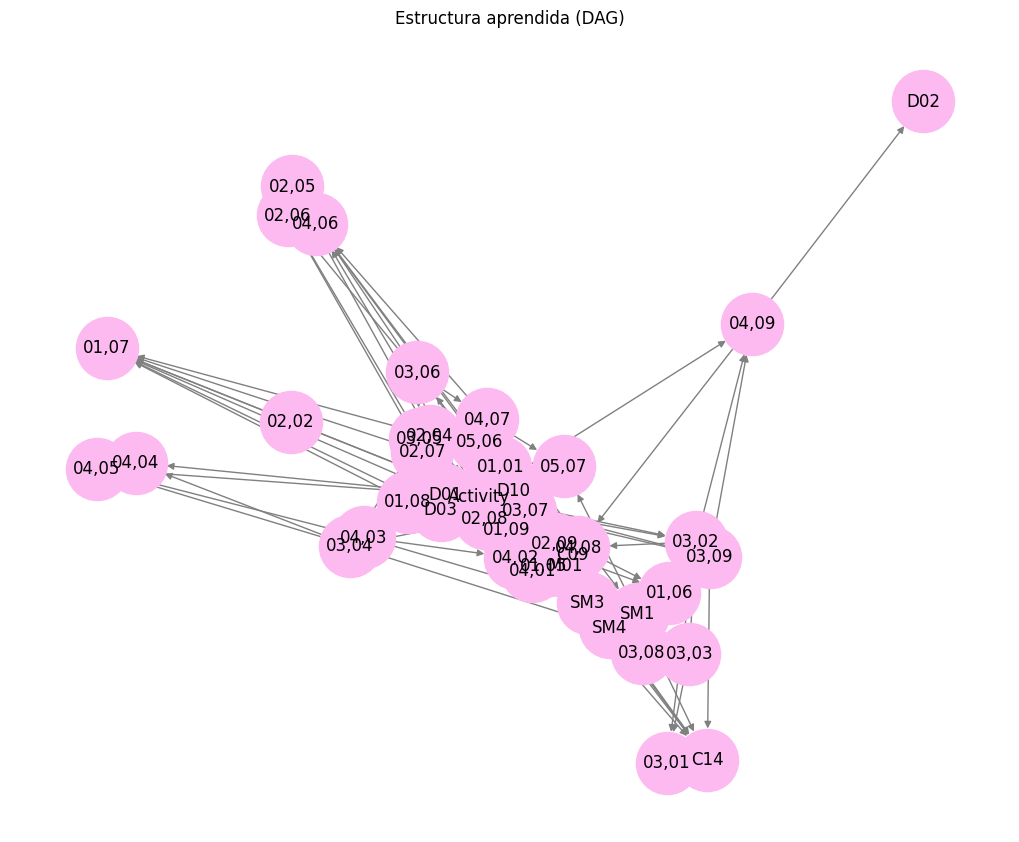

In [287]:
G = nx.DiGraph(model.edges())

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='#FCBAF1', edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

*model.edges()* devuelve las relaciones dirigidas (aristas) que el HillClimbSearch encontró y *DiscreteBayesianNetwork* crea un objeto red bayesiana con esa estructura, pero aún sin los parámetros (probabilidades).

In [288]:
# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Entrenamiento </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

Ajusta los parámetros de la red bayesiana usando los datos del DataFrame **df**.

Usa el método de estimación *Máxima Verosimilitud (MLE)* para calcular las probabilidades condicionadas de cada nodo dados sus padres en la red.

In [289]:
bn.fit(df_train, estimator=MaximumLikelihoodEstimator)
infer = VariableElimination(bn)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C02': 'N', 'C04': 'N', 'C05': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D05': 'N', 'D07': 'N', 'D08': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'S09': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'SM5': 'N', 'TV0': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': '

**TABLAS DE PROBABILIDAD CONDICIONADA**

In [290]:
# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)


CPD de la variable: C09
+--------+--------+---------------------+
| SM3    | SM3(0) | SM3(1)              |
+--------+--------+---------------------+
| C09(0) | 1.0    | 0.9690889370932755  |
+--------+--------+---------------------+
| C09(1) | 0.0    | 0.03091106290672451 |
+--------+--------+---------------------+

CPD de la variable: Activity
+--------------+-----+----------+----------+----------+
| 01,01        | ... | 01,01(1) | 01,01(1) | 01,01(1) |
+--------------+-----+----------+----------+----------+
| 01,05        | ... | 01,05(1) | 01,05(1) | 01,05(1) |
+--------------+-----+----------+----------+----------+
| 01,09        | ... | 01,09(1) | 01,09(1) | 01,09(1) |
+--------------+-----+----------+----------+----------+
| 02,02        | ... | 02,02(1) | 02,02(1) | 02,02(1) |
+--------------+-----+----------+----------+----------+
| 02,04        | ... | 02,04(1) | 02,04(1) | 02,04(1) |
+--------------+-----+----------+----------+----------+
| 02,07        | ... | 02,07(1) | 0

<div style="display: flex; align-items: center;">
    <h3 style="margin: 0;"> Evaluación </h3>
    <hr style="flex-grow: 1; margin-left: 10px; border: none; border-top: 2px solid #FCBAF1;">
</div>

In [269]:
model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta
print(model_vars)
correct = 0

for _, row in df_val.iterrows():
    # Filtrar solo columnas que están en el modelo
    evidence = row[model_vars].to_dict()
    prediction = infer.map_query(['Activity'], evidence=evidence)
    if prediction['Activity'] == row['Activity']:
        correct += 1

accuracy = correct / len(df_val)


['C09', 'SM1', 'C14', '03,01', 'D01', '03,09', '01,07', 'SM4', '04,08', 'D03', 'SM3', '01,06', 'D10', '04,06', 'M01', '05,07', '01,01', '01,05', '01,08', '01,09', '02,09', '02,07', '02,02', '02,04', '02,05', '03,05', '03,07', '03,03', '02,06', '02,08', '03,02', '04,09', '03,04', '04,05', '04,04', '03,06', '04,07', '03,08', '04,01', '04,02', '04,03', 'D02', '05,06']


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
c:\Users\sheil\anaconda3\envs\TFG\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / (phi.values.sum())
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?

KeyboardInterrupt: 

In [ ]:
print(f"Accuracy en validación: {accuracy:.2%}")

Accuracy en validación: 74.90%


<hr style="color:#DA01B5">

## Momento B


<hr style="color:#DA01B5">

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C02': 'N', 'C04': 'N', 'C05': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D05': 'N', 'D07': 'N', 'D08': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'S09': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'SM5': 'N', 'TV0': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': '


Datos de entrenamiento:
(3291, 78)
     C02  C04  C05  C07  C08  C09  C10  C12  C13  C14  ...  05,02  05,03  \
C01                                                    ...                 
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   

     05,04  05,05  05,06  05,07  05,08  05,09  05,10  Activity  
C01                                                             
0        0      0      0      0      0      0      0         3  
0        0      0      0      0      0      0      0         9  
0        0      0      0      1      0      0      0         6  
0        0      0      0      0      0      0      0         3  
0        0      0      0      0      0   

  0%|          | 151/1000000 [00:58<106:59:11,  2.60it/s]


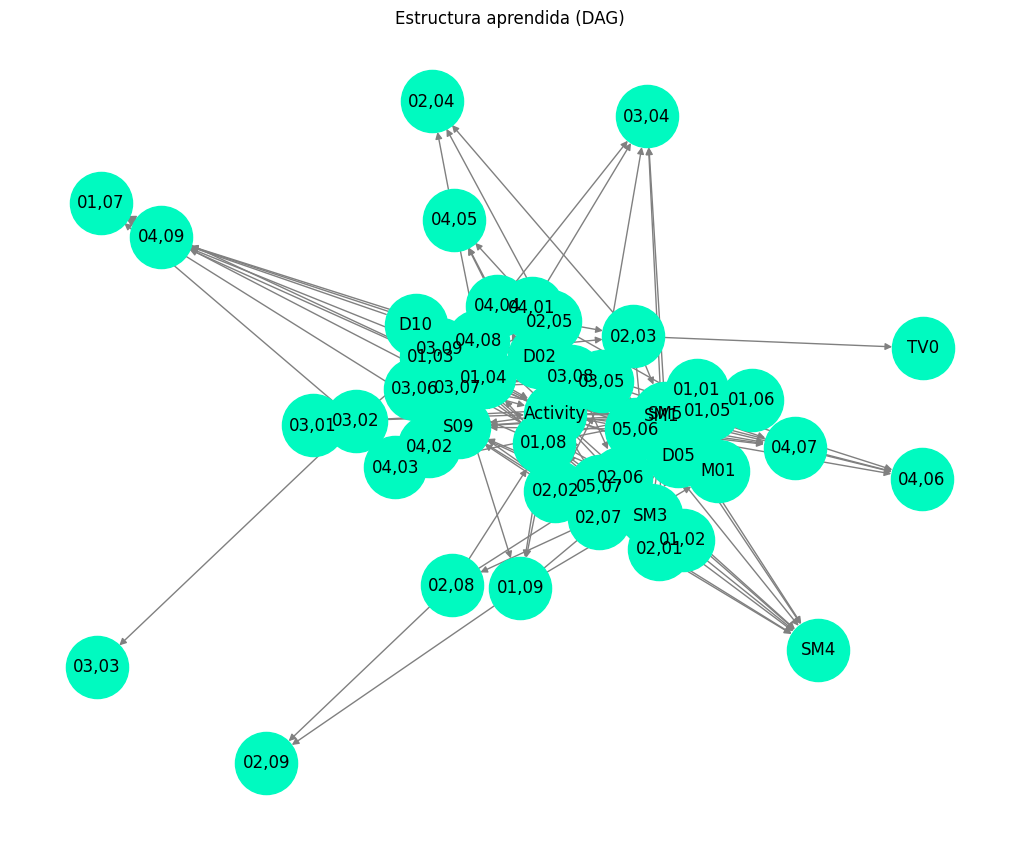

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C02': 'N', 'C04': 'N', 'C05': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D05': 'N', 'D07': 'N', 'D08': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'S09': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'SM5': 'N', 'TV0': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': '


CPD de la variable: D02
+--------+------------+
| D02(0) | 0.998633   |
+--------+------------+
| D02(1) | 0.00136705 |
+--------+------------+

CPD de la variable: 04,08
+----------+--------------------+-----+--------------+--------------+
| 03,08    | 03,08(0)           | ... | 03,08(1)     | 03,08(1)     |
+----------+--------------------+-----+--------------+--------------+
| 04,05    | 04,05(0)           | ... | 04,05(1)     | 04,05(1)     |
+----------+--------------------+-----+--------------+--------------+
| 05,06    | 05,06(0)           | ... | 05,06(1)     | 05,06(1)     |
+----------+--------------------+-----+--------------+--------------+
| Activity | Activity(1)        | ... | Activity(22) | Activity(22) |
+----------+--------------------+-----+--------------+--------------+
| D02      | D02(0)             | ... | D02(1)       | D02(1)       |
+----------+--------------------+-----+--------------+--------------+
| D10      | D10(0)             | ... | D10(0)       | D10

In [325]:
letter = 'B'
df = pd.read_csv(f'Data\\data_{letter}.csv', sep=',', index_col=0)
# Eliminamos la ultima columna que no contiene información relevante
df = df.drop(columns=['DAY'])

# Eliminamos las filas que tienen un valor 0 en la columna 'Activity'
df = df[df['Activity'] != 0]
# Dividimos ahora trainval en train y validación
df_train, df_val = train_test_split(df, test_size=0.25, random_state=40, stratify=df['Activity'])

print("\n\033[1;32mDatos de entrenamiento:\033[0m")
print(df_train.shape)
print(df_train.head())
print("\n\033[1;32mDatos de validación:\033[0m")
print(df_val.shape)
print(df_val.head())

# Aprender la estructura de la red bayesiana 
hc = HillClimbSearch(df)
model = hc.estimate(scoring_method="k2", epsilon=1e-13, max_iter=1e6, max_indegree=9, show_progress=True)

G = nx.DiGraph(model.edges())

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color="#00FAC0", edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())
bn.fit(df, estimator=MaximumLikelihoodEstimator)

infer = VariableElimination(bn)

# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)

model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta
print(model_vars)

#correct = 0

#for _, row in df_val.iterrows():
    # Filtrar solo columnas que están en el modelo
#    evidence = row[model_vars].to_dict()
#    prediction = infer.map_query(['Activity'], evidence=evidence)
#    if prediction['Activity'] == row['Activity']:
#        correct += 1

#accuracy = correct / len(df_val)

#print(f"Accuracy en validación: {accuracy:.2%}")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C02': 'N', 'C04': 'N', 'C05': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D05': 'N', 'D07': 'N', 'D08': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'S09': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'SM5': 'N', 'TV0': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': '

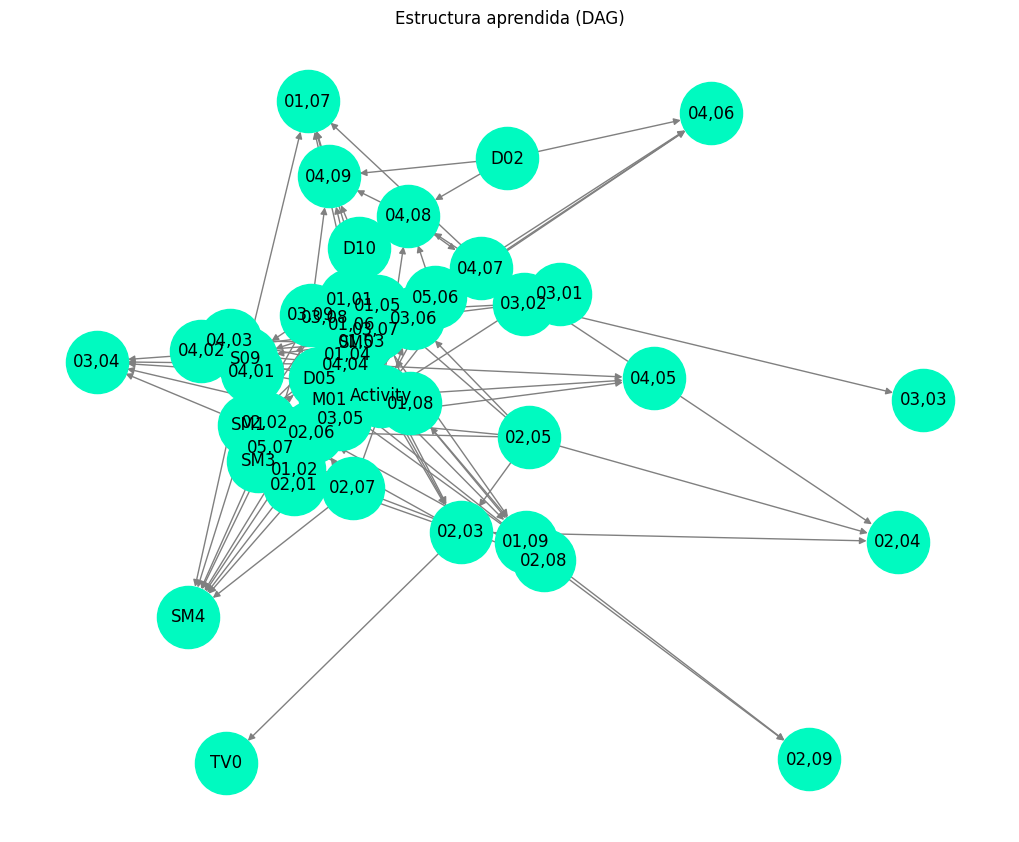

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C02': 'N', 'C04': 'N', 'C05': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C12': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D05': 'N', 'D07': 'N', 'D08': 'N', 'D09': 'N', 'D10': 'N', 'H01': 'N', 'M01': 'N', 'S09': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'SM5': 'N', 'TV0': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': '

In [332]:
letter, max_indregree_letter = 'B', 9  # Cambiar según la letra
# Cargamos los datos
df = pd.read_csv(f'..\\Red Bayesiana\\Data\\data_{letter}.csv', sep=',', index_col=0)

# Eliminamos la ultima columna que no contiene información relevante
df = df.drop(columns=['DAY'])
# Eliminamos las filas que tienen un valor 0 en la columna 'Activity'
df = df[df['Activity'] != 0]

# --------
# MODELO
# --------

# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df)
model = hc.estimate(scoring_method='k2', epsilon=1e-13, max_iter=1e6, max_indegree=max_indregree_letter)

# Visualización de la estructura aprendida
G = nx.DiGraph(model.edges())
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color="#00FAC0", edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

# Ajustar el modelo a los datos
bn = DiscreteBayesianNetwork(model.edges())
bn.fit(df, estimator=MaximumLikelihoodEstimator)

In [333]:
infer = VariableElimination(bn)

# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)

model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta
print(model_vars)


CPD de la variable: D02
+--------+------------+
| D02(0) | 0.998633   |
+--------+------------+
| D02(1) | 0.00136705 |
+--------+------------+

CPD de la variable: 04,08
+----------+--------------------+-----+--------------+--------------+
| 03,08    | 03,08(0)           | ... | 03,08(1)     | 03,08(1)     |
+----------+--------------------+-----+--------------+--------------+
| 04,05    | 04,05(0)           | ... | 04,05(1)     | 04,05(1)     |
+----------+--------------------+-----+--------------+--------------+
| 05,06    | 05,06(0)           | ... | 05,06(1)     | 05,06(1)     |
+----------+--------------------+-----+--------------+--------------+
| Activity | Activity(1)        | ... | Activity(22) | Activity(22) |
+----------+--------------------+-----+--------------+--------------+
| D02      | D02(0)             | ... | D02(1)       | D02(1)       |
+----------+--------------------+-----+--------------+--------------+
| D10      | D10(0)             | ... | D10(0)       | D10

In [337]:
i,letter= 1,'B'
days = ['2017-11-09', '2017-11-13', '2017-11-21']

df_test = pd.read_csv(f'..\\Predicciones\\Data_test\\{days[i]}\\{days[i]}-{letter}.csv', sep=',', index_col=0)
df_test = df_test.drop(columns=['DAY'])

# -------------
# PREDICCIONES
# -------------

predictions = []

for _, row in df_test.iterrows():
    # Filtrar solo columnas que están en el modelo
    evidence = row[model_vars].to_dict()
    prediction = infer.map_query(['Activity'], evidence=evidence)
    predictions.append({
        "TIME_BEGIN": row["TIME_BEGIN"],
        "TIME_END": row["TIME_END"],
        "PREDICCION": prediction["Activity"]
    })

# Convertimos a DataFrame
df_predicciones = pd.DataFrame(predictions)

df_predicciones

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

,TIME_BEGIN,TIME_END,PREDICCION
0,12:39:48,12:39:48,6
1,12:39:49,12:39:49,6
2,12:39:50,12:39:51,3
3,12:39:52,12:39:58,6
4,12:39:59,12:39:59,6
...,...,...,...
854,13:17:39,13:17:42,1
855,13:17:43,13:17:43,9
856,13:17:44,13:17:45,9
857,13:17:46,13:17:51,9


In [338]:
from pathlib import Path
import pandas as pd

# --- parámetros del GT ---
day    = "2017-11-13"
letter = "B"
df_test = pd.read_csv(f'..\\Predicciones\\Data_test\\{days[i]}\\{days[i]}-{letter}.csv', sep=',', index_col=0)
# Ruta del GT: Data\Test2\2017-11-21\2017-11-21-B\2017-11-21-B-activity.csv
gt = pd.read_csv(f'..\\Data\\Test2\\{day}\\{day}-{letter}\\{day}-{letter}-activity.csv', sep=',')
print(gt)
# 1) Cargar GT y tomar el primer timestamp y el número de ventanas (N)

gt["TIMESTAMP"] = pd.to_datetime(gt["TIMESTAMP"], errors="coerce")
gt = gt.dropna(subset=["TIMESTAMP"]).sort_values("TIMESTAMP").reset_index(drop=True)

gt_start = gt["TIMESTAMP"].iloc[0]   # ancla
N        = len(gt)              # nº de ventanas de 30 s en el GT

# 2) Preparar predicciones (df_predicciones): llevar TIME_BEGIN al mismo día del GT
df = df_predicciones.copy()
base_date = gt_start.normalize()  # fecha del GT (00:00)
df["TIME_BEGIN_dt"] = pd.to_datetime(
    base_date.strftime("%Y-%m-%d") + " " + df["TIME_BEGIN"].astype(str),
    errors="coerce"
)
df = df.dropna(subset=["TIME_BEGIN_dt"]).sort_values("TIME_BEGIN_dt").reset_index(drop=True)

# Opcional: descartar predicciones anteriores al inicio del GT
df = df[df["TIME_BEGIN_dt"] >= gt_start].copy()

# 3) Índice de ventana de 30 s respecto al inicio del GT
df["win_idx"] = ((df["TIME_BEGIN_dt"] - gt_start).dt.total_seconds() // 30).astype(int)

# === 4) y 5) y 6) → TOP-2 por duración dentro de cada ventana de 30s ===

# A) Parsear TIME_END al mismo día del GT y asegurar duración mínima
df["TIME_END_dt"] = pd.to_datetime(
    base_date.strftime("%Y-%m-%d") + " " + df["TIME_END"].astype(str),
    errors="coerce"
)
# si TIME_END_dt es NaT, usa TIME_BEGIN_dt
df["TIME_END_dt"] = df["TIME_END_dt"].fillna(df["TIME_BEGIN_dt"])
# si END <= BEGIN, forzamos 1s para que compute duración
mask_bad = df["TIME_END_dt"] <= df["TIME_BEGIN_dt"]
df.loc[mask_bad, "TIME_END_dt"] = df.loc[mask_bad, "TIME_BEGIN_dt"] + pd.to_timedelta(1, unit="s")

# B) Construir rejilla de ventanas [start, end) ancladas al GT
wins = pd.DataFrame({"win_idx": range(N)})
wins["win_start"] = gt_start + pd.to_timedelta(wins["win_idx"] * 30, unit="s")
wins["win_end"]   = wins["win_start"] + pd.Timedelta(seconds=30)

# C) Para cada ventana, sumar duración por etiqueta y quedarnos con el TOP-2
rows = []
for _, w in wins.iterrows():
    w_start, w_end = w["win_start"], w["win_end"]

    # filas que solapan con la ventana
    mask = (df["TIME_END_dt"] > w_start) & (df["TIME_BEGIN_dt"] < w_end)
    sub = df.loc[mask, ["TIME_BEGIN_dt", "TIME_END_dt", "PREDICCION"]].copy()

    if sub.empty:
        rows.append({"TIMESTAPMP": w_start, "Activity_1": "0", "Activity_2": "0"})
        continue

    # recortar a los límites de la ventana
    sub["overlap_start"] = sub["TIME_BEGIN_dt"].clip(lower=w_start)
    sub["overlap_end"]   = sub["TIME_END_dt"].clip(upper=w_end)
    sub["dur"] = (sub["overlap_end"] - sub["overlap_start"]).dt.total_seconds()
    sub.loc[sub["dur"] < 0, "dur"] = 0  # seguridad numérica

    # duración total por actividad
    dur = sub.groupby("PREDICCION", sort=False)["dur"].sum()
    # desempate por aparición más temprana en la ventana
    first_seen = sub.groupby("PREDICCION")["overlap_start"].min()

    # ordenar: mayor duración, y si empatan el que apareció antes
    order = sorted(dur.index, key=lambda k: (-dur[k], first_seen[k]))

    top1 = str(order[0]) if len(order) >= 1 and dur[order[0]] > 0 else "0"
    top2 = str(order[1]) if len(order) >= 2 and dur[order[1]] > 0 else "0"

    rows.append({"TIMESTAPMP": w_start, "Activity_1": top1, "Activity_2": top2})

# D) DataFrame final por ventanas de 30s
df_30s = pd.DataFrame(rows)[["TIMESTAPMP", "Activity_1", "Activity_2"]]

# (Opcional) si quieres solo la hora:
# df_30s["TIMESTAPMP"] = df_30s["TIMESTAPMP"].dt.strftime("%H:%M:%S")

print(df_30s.head(20))


              TIMESTAMP  Act10  Act03  Act06  Act01  Act19  Act15  Act17  \
0   2017-11-13 12:39:30  False  False  False  False  False  False  False   
1   2017-11-13 12:40:00   True  False  False  False  False  False  False   
2   2017-11-13 12:40:30   True  False  False  False  False  False  False   
3   2017-11-13 12:41:00  False   True  False  False  False  False  False   
4   2017-11-13 12:41:30  False   True  False  False  False  False  False   
..                  ...    ...    ...    ...    ...    ...    ...    ...   
74  2017-11-13 13:16:30  False  False  False  False  False  False  False   
75  2017-11-13 13:17:00  False  False  False  False  False  False  False   
76  2017-11-13 13:17:30  False  False  False  False  False  False  False   
77  2017-11-13 13:18:00  False  False  False  False  False  False  False   
78  2017-11-13 13:18:30  False  False  False  False  False  False  False   

    Act12  Act13 Activity_1 Activity_2  
0   False  False       Idle       Idle  
1   F

In [339]:
# 0) Asegurar tiempos y ordenar
gt["TIMESTAMP"] = pd.to_datetime(gt["TIMESTAMP"], errors="coerce")
df_30s["TIMESTAPMP"] = pd.to_datetime(df_30s["TIMESTAPMP"], errors="coerce")

gt = gt.dropna(subset=["TIMESTAMP"]).sort_values("TIMESTAMP").reset_index(drop=True)
df_30s = df_30s.dropna(subset=["TIMESTAPMP"]).sort_values("TIMESTAPMP").reset_index(drop=True)

# 1) Normalizador de etiquetas: 0/NaN -> 'Idle', números -> 'ActN', resto se deja igual
def norm_label(v):
    if pd.isna(v):
        return "Idle"
    s = str(v).strip()
    if s == "" or s == "0":
        return "Idle"
    try:
        n = int(float(s))
        return f"Act{n}"
    except Exception:
        return s

# 2) Predicciones: mapea tus dos columnas
pred = df_30s.rename(columns={"TIMESTAPMP": "TIMESTAMP"}).copy()
pred["Pred1"] = pred["Activity_1"].apply(norm_label)
pred["Pred2"] = pred["Activity_2"].apply(norm_label)

# 3) Ground truth: toma sus dos columnas
gt_ref = gt.copy()
gt_ref["GT1"] = gt_ref["Activity_1"].apply(norm_label)
gt_ref["GT2"] = gt_ref["Activity_2"].apply(norm_label)

# 4) Unir por TIMESTAMP
comp = pd.merge(
    gt_ref[["TIMESTAMP", "GT1", "GT2"]],
    pred[["TIMESTAMP", "Pred1", "Pred2"]],
    on="TIMESTAMP",
    how="left"
)

# Completar predicciones faltantes con Idle
comp["Pred1"] = comp["Pred1"].fillna("Idle")
comp["Pred2"] = comp["Pred2"].fillna("Idle")

# 5) Acierto si cualquiera coincide
comp["correct"] = (
    (comp["Pred1"] == comp["GT1"]) |
    (comp["Pred1"] == comp["GT2"]) |
    (comp["Pred2"] == comp["GT1"]) |
    (comp["Pred2"] == comp["GT2"])
)

acc = comp["correct"].mean()
print(f"Accuracy 30s (match en cualquiera de las dos): {acc:.2%}")

# (Opcional) primeras discrepancias
errores = comp[~comp["correct"]][["TIMESTAMP", "GT1", "GT2", "Pred1", "Pred2"]]
print("\nPrimeras discrepancias:")
print(errores.head(10))


Accuracy 30s (match en cualquiera de las dos): 7.59%

Primeras discrepancias:
             TIMESTAMP    GT1    GT2 Pred1  Pred2
0  2017-11-13 12:39:30   Idle   Idle  Act6   Act3
1  2017-11-13 12:40:00  Act10  Act10  Act6  Act15
3  2017-11-13 12:41:00  Act03  Act03  Act3   Act6
4  2017-11-13 12:41:30  Act03  Act03  Act6   Act3
5  2017-11-13 12:42:00  Act03  Act03  Act3   Act6
6  2017-11-13 12:42:30  Act03  Act03  Act3   Act6
7  2017-11-13 12:43:00  Act03  Act03  Act6   Act3
8  2017-11-13 12:43:30  Act03  Act03  Act6   Act3
9  2017-11-13 12:44:00  Act03  Act03  Act6   Act3
10 2017-11-13 12:44:30  Act03  Act03  Act3   Act6


<hr style="color:#DA01B5">

## Momento C

<hr style="color:#DA01B5">

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C05': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D05': 'N', 'D07': 'N', 'D08': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'SM5': 'N', 'TV0': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': 'N', '05,02': 'N', '05,03': 'N', '05,04': 'N', '05,05': 'N', 


Datos de entrenamiento:
(2299, 73)
     C04  C05  C07  C08  C09  C10  C13  C14  D01  D02  ...  05,02  05,03  \
C01                                                    ...                 
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    0    0    0    1    0    0  ...      0      0   
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
0      0    0    0    0    1    0    0    0    0    0  ...      0      0   

     05,04  05,05  05,06  05,07  05,08  05,09  05,10  Activity  
C01                                                             
0        0      0      0      0      0      0      0        11  
0        0      0      0      0      0      0      0         7  
0        0      0      0      0      0      0      0         4  
0        0      0      0      0      0      0      0        17  
0        0      0      0      0      0   

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C05': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D05': 'N', 'D07': 'N', 'D08': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'SM5': 'N', 'TV0': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': 'N', '05,02': 'N', '05,03': 'N', '05,04': 'N', '05,05': 'N', 

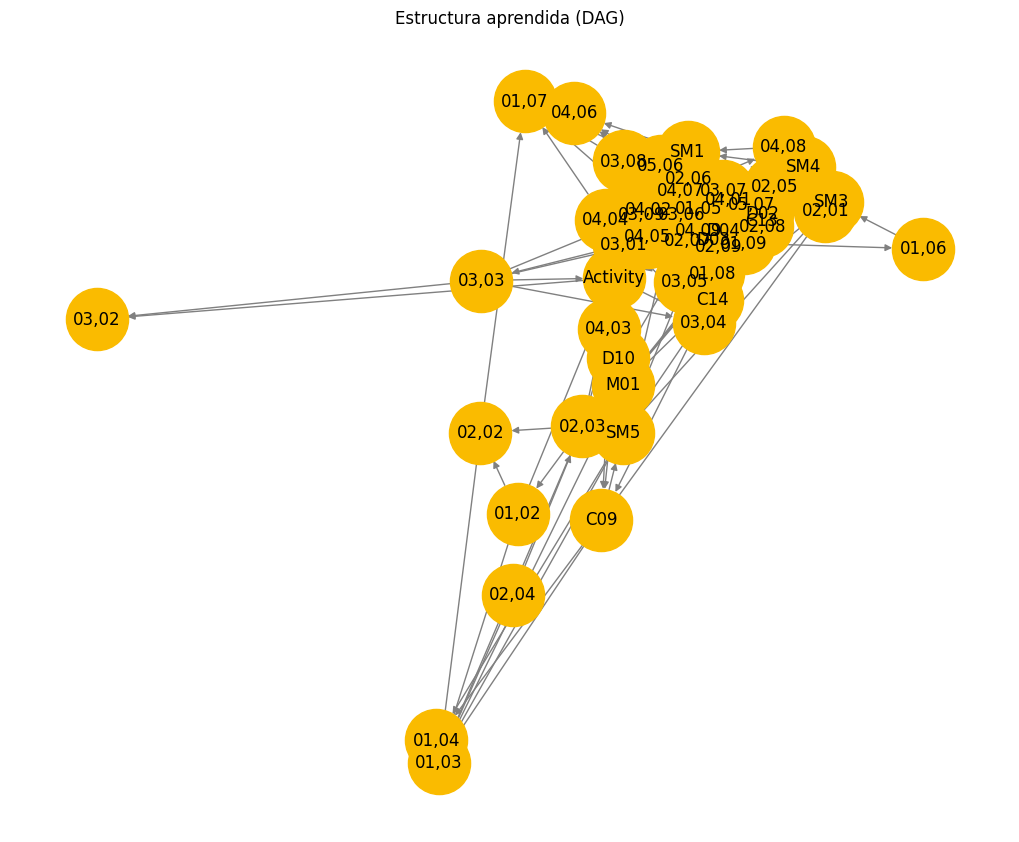

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C04': 'N', 'C05': 'N', 'C07': 'N', 'C08': 'N', 'C09': 'N', 'C10': 'N', 'C13': 'N', 'C14': 'N', 'D01': 'N', 'D02': 'N', 'D03': 'N', 'D04': 'N', 'D05': 'N', 'D07': 'N', 'D08': 'N', 'D10': 'N', 'M01': 'N', 'SM1': 'N', 'SM3': 'N', 'SM4': 'N', 'SM5': 'N', 'TV0': 'N', '01,01': 'N', '01,02': 'N', '01,03': 'N', '01,04': 'N', '01,05': 'N', '01,06': 'N', '01,07': 'N', '01,08': 'N', '01,09': 'N', '01,10': 'N', '02,01': 'N', '02,02': 'N', '02,03': 'N', '02,04': 'N', '02,05': 'N', '02,06': 'N', '02,07': 'N', '02,08': 'N', '02,09': 'N', '02,10': 'N', '03,01': 'N', '03,02': 'N', '03,03': 'N', '03,04': 'N', '03,05': 'N', '03,06': 'N', '03,07': 'N', '03,08': 'N', '03,09': 'N', '03,10': 'N', '04,01': 'N', '04,02': 'N', '04,03': 'N', '04,04': 'N', '04,05': 'N', '04,06': 'N', '04,07': 'N', '04,08': 'N', '04,09': 'N', '04,10': 'N', '05,01': 'N', '05,02': 'N', '05,03': 'N', '05,04': 'N', '05,05': 'N', 


CPD de la variable: C09
+----------+-------------+-----+--------------+--------------+
| Activity | Activity(1) | ... | Activity(23) | Activity(23) |
+----------+-------------+-----+--------------+--------------+
| C14      | C14(0)      | ... | C14(1)       | C14(1)       |
+----------+-------------+-----+--------------+--------------+
| D10      | D10(0)      | ... | D10(0)       | D10(1)       |
+----------+-------------+-----+--------------+--------------+
| C09(0)   | 1.0         | ... | 1.0          | 0.5          |
+----------+-------------+-----+--------------+--------------+
| C09(1)   | 0.0         | ... | 0.0          | 0.5          |
+----------+-------------+-----+--------------+--------------+

CPD de la variable: SM5
+----------+-------------+-----+--------------+--------------+
| 02,03    | 02,03(0)    | ... | 02,03(1)     | 02,03(1)     |
+----------+-------------+-----+--------------+--------------+
| 03,05    | 03,05(0)    | ... | 03,05(1)     | 03,05(1)     |
+----

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

Accuracy en validación: 72.23%


In [281]:
letter = 'C'
df = pd.read_csv(f'Data\\data_{letter}.csv', sep=',', index_col=0)
# Eliminamos la ultima columna que no contiene información relevante
df = df.drop(columns=['DAY'])

# Eliminamos las filas que tienen un valor 0 en la columna 'Activity'
df = df[df['Activity'] != 0]
# Dividimos ahora trainval en train y validación
df_train, df_val = train_test_split(df, test_size=0.25, random_state=40, stratify=df['Activity'])

print("\n\033[1;32mDatos de entrenamiento:\033[0m")
print(df_train.shape)
print(df_train.head())
print("\n\033[1;32mDatos de validación:\033[0m")
print(df_val.shape)
print(df_val.head())

# Aprender la estructura de la red bayesiana
hc = HillClimbSearch(df_train)
model = hc.estimate(scoring_method="k2", epsilon=1e-13, max_iter=1e6, max_indegree=14, show_progress=True)

G = nx.DiGraph(model.edges())

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color="#FABB00", edge_color='gray', node_size=2000, font_size=12)
plt.title("Estructura aprendida (DAG)")
plt.show()

# Aprender parámetros
bn = DiscreteBayesianNetwork(model.edges())
bn.fit(df_train, estimator=MaximumLikelihoodEstimator)

infer = VariableElimination(bn)

# Mostrar CPTs
for cpd in bn.get_cpds():
    print(f"\nCPD de la variable: {cpd.variable}")
    print(cpd)

model_vars = list(bn.nodes())  # Variables que el modelo sí conoce
model_vars.remove('Activity')  # Queremos predecir esta
print(model_vars)

correct = 0

for _, row in df_val.iterrows():
    # Filtrar solo columnas que están en el modelo
    evidence = row[model_vars].to_dict()
    prediction = infer.map_query(['Activity'], evidence=evidence)
    if prediction['Activity'] == row['Activity']:
        correct += 1

accuracy = correct / len(df_val)

print(f"Accuracy en validación: {accuracy:.2%}")